In [1]:
import os

import pandas as pd
from clearml import Task

import matplotlib.pyplot as plt
import seaborn as sns

# Utils

In [2]:
# project_name = 'AA_attack_run_GOLDEN'
# #project_name = 'attacks_examples'
# tags_filter = ["__$all", 'Dima', 'Strawberry']
# tags_filter = []

# tags_iteration = [['Dmitry'], ['Sophie']]
# metrics = pd.DataFrame()

# for tags in tags_iteration:
#     tasks = Task.get_tasks(project_name=project_name, tags=tags)
#     # task_example = tasks[-1]
#     print(len(tasks))

#     metrics_ = pd.DataFrame()

#     for task in tasks:
#         task_name = task.name
#         print(task_name) 
#         scalars = task.get_reported_scalars()
#         # experiments[task_name] = scalars
#         #scalars = [scalar for scalar in scalars scalar]

#         df_all_metrics = pd.DataFrame([])

#         for metric_name in scalars:
#             if metric_name[0] == ':':
#                 continue
#             data = scalars[metric_name][metric_name]
#             iters = data['x']
#             values = data['y']
#             df_metric = pd.DataFrame(index=data['x'], columns=[data['name']], data=data['y'])
#             df_all_metrics = df_all_metrics.join(df_metric, how='right')

#         df_all_metrics = df_all_metrics.reset_index()
#         df_all_metrics = df_all_metrics.rename(columns={'index': 'iters'})
#         df_all_metrics['exp_name'] = task_name
#         metrics_ = pd.concat([metrics_, df_all_metrics])
#     metrics = pd.concat([metrics, metrics_])

# metrics.to_csv('../results/attack_metrics_clearml_3.csv')
# metrics

In [3]:
def draw_scatter_pair_metrics(df, x_col, y_col, x_col_name=None, y_col_name=None, title=None):

    n_colors = df['dataset'].nunique()

    # Цветовая палитра для датасетов
    palette = sns.color_palette("hls", n_colors)

    # Формы точек для моделей
    markers = ['o', 's', 'D', '^', '<', '>']

    plt.figure(figsize=[5, 5], dpi=300)

    # Создание scatterplot
    sns.scatterplot(
        x=x_col, 
        y=y_col, 
        hue='dataset', 
        style='model',
        data=df,
        palette=palette,
        markers=markers,
        s=100
    )

    if not x_col_name:
        x_col_name = x_col
    
    if not y_col_name:
        y_col_name = y_col

    # Настройка графика
    plt.xlabel(x_col_name)
    plt.ylabel(y_col_name)
    plt.xlim(-0.02, 1.02)
    plt.ylim(-0.02, 1.02)

    # Диагональная линия
    plt.plot([0, 1], [0, 1], 'k--')

    if title:
        plt.title(title)

    # Легенда
    plt.legend(title='Model / Dataset', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid()
    # plt.title('Изменение метрики атаки с дискриминатором и без дискриминатора')
    # # Отображение графика
    # plt.tight_layout()
    plt.show()


In [4]:
def load_local_data(datasets, models, prefixes, flag_test=True):
    results = pd.DataFrame()

    for dataset in datasets:
        df_dataset = pd.DataFrame()
        for model in models:
            model_data = pd.DataFrame()
            path = f'../results/{dataset}/{model}/attack'

            try:
                experiments = os.listdir(path)                
                for exp_folder in experiments:
                    if exp_folder[0] == '.':
                        continue
                    exp_path = os.path.join(path, exp_folder)
                    exp_params = [exp for exp in os.listdir(exp_path) if '.csv' in exp]
                    
                    exp_data = pd.DataFrame()
                    for param_file in exp_params:
                        metric_path = os.path.join(exp_path, param_file)
                        param_df = pd.read_csv(metric_path)
                        #print(metric_path)
                        
                        exp_full_name = param_file.replace('.csv', '')
                        # exp_full_name
                        # for prefix in prefixes:

                        #     print(prefix in exp_name)
                        #     exp_name = exp_name.replace(exp_full_name, '')
                        #     while exp_name[-1] == '_':
                        #         exp_name = exp_name[:-1]
                        param_df['full_exp_name'] = exp_full_name
                        
                        param_df.columns = [col.strip() for col in param_df.columns]

                        exp_data = pd.concat([exp_data, param_df], axis=0)
                    
                    exp_name = exp_folder
                    exp_data['experiment'] = exp_name

                    exp_data['model'] = model
                    exp_data['dataset'] = dataset

                    if len(exp_data.columns) > 22 or flag_test:
                        flag_test = False
                    model_data = pd.concat([model_data, exp_data], axis=0)
            except:
                print(path)
            
            df_dataset = pd.concat([df_dataset, model_data], axis=0)
        results = pd.concat([results, df_dataset], axis=0)

    return results

# Load 

In [5]:
# dataset = 'PowerCons'
# model = 'ResidualCNN'

results = load_local_data(
    datasets = ['GunPointMaleVersusFemale', 'Strawberry', 'PowerCons', 'GunPoint', 'Coffee', 'FreezerRegularTrain'],
    models = ['ResidualCNN', 'PatchTST', 'S4', 'RNNA'], # ['S4', 'ResidualCNN', 'TST', 'PatchTST', 'RNNA']
    prefixes = ['fast_run', 'test'],
    flag_test = True,
)


mask = \
    (results['full_exp_name'].str.contains('pgd')) | \
    (results['full_exp_name'].str.contains('harmonic')) | \
    (results['full_exp_name'].str.contains('hypercones')) | \
    (results['full_exp_name'].str.contains('simba')) | \
    (results['full_exp_name'].str.contains('kll2')) | \
    (
        results['full_exp_name'].str.contains('fgsm') & \
        (results['dataset'] == 'PowerCons') & results['model'].isin(['PatchTST', 'ResidualCNN', 'S4', 'RNNA'])
)
results = results[mask].rename(columns={'step_id': 'iters'})
results['exp_name'] = results['full_exp_name']

In [6]:
res_check = results[~results['full_exp_name'].str.contains('pgd')]

res_check['exp_name'] = res_check['exp_name'].str.replace('__', '|')
res_check['exp_name_no_params'], res_check['exp_params'] = res_check['exp_name'].str.split('|', n=1).str

res_check['exp_params'] = res_check['exp_params'].str.split('|')
res_check['dataset'].unique()

/tmp/ipykernel_558137/3510677327.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_check['exp_name'] = res_check['exp_name'].str.replace('__', '|')
/tmp/ipykernel_558137/3510677327.py:4: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  res_check['exp_name_no_params'], res_check['exp_params'] = res_check['exp_name'].str.split('|', n=1).str
/tmp/ipykernel_558137/3510677327.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_check['exp_name_no_params'], res_c

array(['GunPointMaleVersusFemale', 'Strawberry', 'PowerCons', 'GunPoint',
       'Coffee', 'FreezerRegularTrain'], dtype=object)

In [7]:
bad_exp = [exp for exp in res_check.full_exp_name.unique() if len(exp) < 30]
res_check[res_check['full_exp_name'].isin(bad_exp)]['exp_name'].unique()

array([], dtype=object)

# Transform

In [8]:
metrics = pd.read_csv('../results/attack_metrics_clearml_3.csv', index_col=0)

na_mask = metrics.T.isna().sum() > 0
metrics = metrics[~na_mask]

metrics.head()

,iters,ACC,ACC_CORRECT,ACC_DISC,ACC_ORIG_ADV,CONC,EFF,F1,F1_DISC,F_EFF_CONC,L1,PR,PROB_HID,ROC,ROC_AUC_DISC,ROUGHNESS,ROUGHNESS_NORM,exp_name
0,0,0.977895,1.000000,0.982456,1.000000,0.000000,0.022005,0.977995,0.000000,0.000000,0.000000,0.965266,0.021848,0.977895,1.000000,0.044127,1.000000,model_RNNA_100_FreezerRegularTrain_attack_fgsm_disc_attack__eps=0.005__n_steps=50__alpha=0.0001
1,1,0.951579,0.973089,0.500175,0.973684,0.509884,0.047553,0.952447,0.034565,0.086994,1.505000,0.922534,0.022083,0.951579,0.490116,0.045802,1.037978,model_RNNA_100_FreezerRegularTrain_attack_fgsm_disc_attack__eps=0.005__n_steps=50__alpha=0.0001
2,2,0.918246,0.939003,0.500702,0.940351,0.475143,0.079333,0.920667,0.036561,0.135964,2.775684,0.873987,0.024397,0.918246,0.524857,0.047355,1.073161,model_RNNA_100_FreezerRegularTrain_attack_fgsm_disc_attack__eps=0.005__n_steps=50__alpha=0.0001
3,3,0.881404,0.901328,0.501579,0.903509,0.412841,0.114344,0.885656,0.039878,0.179086,4.075333,0.826099,0.029835,0.881404,0.587160,0.049146,1.113756,model_RNNA_100_FreezerRegularTrain_attack_fgsm_disc_attack__eps=0.005__n_steps=50__alpha=0.0001
4,4,0.843860,0.862935,0.503509,0.865965,0.343764,0.151206,0.848794,0.047138,0.210030,5.184747,0.782925,0.041206,0.843860,0.656236,0.051147,1.159093,model_RNNA_100_FreezerRegularTrain_attack_fgsm_disc_attack__eps=0.005__n_steps=50__alpha=0.0001


In [9]:
metrics['iters'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])

In [10]:
metrics = pd.concat([metrics, results])

In [11]:
metrics['exp_name'] = metrics['exp_name'].str.replace('__', '|')
metrics['exp_name_no_params'], metrics['exp_params'] = metrics['exp_name'].str.split('|', n=1).str

metrics['exp_params'] = metrics['exp_params'].str.split('|')
metrics['exp_params'] = metrics['exp_params'].apply(lambda x_list: {x.split('=')[0]:x.split('=')[1] for x in x_list})
metrics = pd.concat([metrics.reset_index(drop=True), pd.json_normalize(metrics['exp_params'])], axis=1)
metrics = metrics.drop(columns=['exp_params'])

metrics['_'], metrics['model'], metrics['seed'], metrics['dataset'], metrics['attack'] = \
    metrics['exp_name_no_params'].str.split('_', n=4).str
metrics = metrics.drop(columns=['_'])

metrics['attack'] = metrics['attack'].apply(
    lambda x: '_'.join([word for word in x.split('_') if word != 'attack'])
)
metrics['attack_type'] = metrics['attack'].str.split('_').str[0]
metrics['disc_attack'] = metrics['attack'].str.contains("disc")

metrics.head()

/tmp/ipykernel_558137/2431537609.py:2: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  metrics['exp_name_no_params'], metrics['exp_params'] = metrics['exp_name'].str.split('|', n=1).str
/tmp/ipykernel_558137/2431537609.py:9: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  metrics['_'], metrics['model'], metrics['seed'], metrics['dataset'], metrics['attack'] = \


,iters,ACC,ACC_CORRECT,ACC_DISC,ACC_ORIG_ADV,CONC,EFF,F1,F1_DISC,F_EFF_CONC,...,alpha,eta,smoothness,mu,norm_coef,delta,seed,attack,attack_type,disc_attack
0,0.0,0.977895,1.000000,0.982456,1.000000,0.000000,0.022005,0.977995,0.000000,0.000000,...,0.0001,NaN,NaN,NaN,NaN,NaN,100,fgsm_disc,fgsm,True
1,1.0,0.951579,0.973089,0.500175,0.973684,0.509884,0.047553,0.952447,0.034565,0.086994,...,0.0001,NaN,NaN,NaN,NaN,NaN,100,fgsm_disc,fgsm,True
2,2.0,0.918246,0.939003,0.500702,0.940351,0.475143,0.079333,0.920667,0.036561,0.135964,...,0.0001,NaN,NaN,NaN,NaN,NaN,100,fgsm_disc,fgsm,True
3,3.0,0.881404,0.901328,0.501579,0.903509,0.412841,0.114344,0.885656,0.039878,0.179086,...,0.0001,NaN,NaN,NaN,NaN,NaN,100,fgsm_disc,fgsm,True
4,4.0,0.843860,0.862935,0.503509,0.865965,0.343764,0.151206,0.848794,0.047138,0.210030,...,0.0001,NaN,NaN,NaN,NaN,NaN,100,fgsm_disc,fgsm,True


In [12]:
hid_col = 'F1'
conc_col = 'F1_DISC'

metrics['EFF'] = 1 - metrics[hid_col]
metrics['CONC'] = 1 - metrics[conc_col]
metrics['F_EFF_CONC'] = 2 * metrics['EFF']  * metrics['CONC'] / (metrics['EFF'] + metrics['CONC'])

In [13]:
mask = (metrics['model'] == 'ResidualCNN') & (metrics['dataset'] == 'PowerCons') # & (metrics['attack'] == 'fgsm')
metrics[mask]['attack'].unique()

array(['fgsm_harmonic', 'fgsm', 'kll2', 'fgsm_disc_hypercones',
       'pgd_disc', 'pgd', 'fgsm_disc'], dtype=object)

# Vizualization

In [35]:
metrics.head()

,iters,ACC,ACC_CORRECT,ACC_DISC,ACC_ORIG_ADV,CONC,EFF,F1,F1_DISC,F_EFF_CONC,...,alpha,eta,smoothness,mu,norm_coef,delta,seed,attack,attack_type,disc_attack
0,0.0,0.977895,1.000000,0.982456,1.000000,1.000000,0.022005,0.977995,0.000000,0.043062,...,0.0001,NaN,NaN,NaN,NaN,NaN,100,fgsm_disc,fgsm,True
1,1.0,0.951579,0.973089,0.500175,0.973684,0.965435,0.047553,0.952447,0.034565,0.090642,...,0.0001,NaN,NaN,NaN,NaN,NaN,100,fgsm_disc,fgsm,True
2,2.0,0.918246,0.939003,0.500702,0.940351,0.963439,0.079333,0.920667,0.036561,0.146594,...,0.0001,NaN,NaN,NaN,NaN,NaN,100,fgsm_disc,fgsm,True
3,3.0,0.881404,0.901328,0.501579,0.903509,0.960122,0.114344,0.885656,0.039878,0.204351,...,0.0001,NaN,NaN,NaN,NaN,NaN,100,fgsm_disc,fgsm,True
4,4.0,0.843860,0.862935,0.503509,0.865965,0.952862,0.151206,0.848794,0.047138,0.260996,...,0.0001,NaN,NaN,NaN,NaN,NaN,100,fgsm_disc,fgsm,True


In [36]:
metric_name = 'F_EFF_CONC'

eff_thr = 0.9
pgd_fgsm_iter_thr = 40
simba_iter_thr = 1200
kll2_iter_thr = 350

filter_start_point_mask = (metrics['EFF'] > eff_thr) | \
    (((metrics['attack'].str.contains('fgsm')) | (metrics['attack'].str.contains('pgd'))) & (metrics['iters'] >= pgd_fgsm_iter_thr)) | \
    ((metrics['attack'].str.contains('simba')) & (metrics['iters'] >= simba_iter_thr)) | \
    ((metrics['attack'].str.contains('kll2')) & (metrics['iters'] >= kll2_iter_thr))

filter_start_point_mask = filter_start_point_mask & (metrics['dataset'] != 'Wafer')
grouped_data = metrics[filter_start_point_mask].groupby(by=['dataset', 'model', 'attack'], as_index=False).agg({metric_name: max})
agg_data = grouped_data.pivot(index=['dataset', 'model'], columns='attack', values=metric_name).reset_index()
# agg_data = agg_data.dropna(subset=['fgsm', 'fgsm_disc'])
agg_data

attack,dataset,model,fgsm,fgsm_disc,fgsm_disc_hypercones,fgsm_harmonic,kll2,pgd,pgd_disc
0,Coffee,PatchTST,0.464286,1.000000,NaN,1.000000,0.421839,0.133314,0.557249
1,Coffee,RNNA,0.661935,1.000000,NaN,1.000000,1.000000,0.339363,1.000000
2,Coffee,ResidualCNN,1.000000,1.000000,NaN,1.000000,0.964267,0.035749,1.000000
3,Coffee,S4,0.892537,1.000000,NaN,1.000000,0.894830,NaN,NaN
4,FreezerRegularTrain,PatchTST,0.051125,0.999649,NaN,0.995098,0.457138,0.536994,1.000000
5,FreezerRegularTrain,RNNA,0.075926,0.943598,NaN,NaN,0.242931,0.463535,0.537275
6,FreezerRegularTrain,ResidualCNN,0.996297,0.997156,NaN,0.994310,0.991560,0.647562,0.978764
7,FreezerRegularTrain,S4,0.089920,0.951026,NaN,NaN,0.460167,NaN,NaN
8,GunPoint,PatchTST,0.019608,0.802195,0.421094,0.767398,0.503475,NaN,NaN
9,GunPoint,RNNA,0.013158,0.512798,0.623632,0.459635,NaN,0.179174,0.468627


In [37]:
agg_data_table = grouped_data[grouped_data['attack'] != 'fgsm_disc_hypercones'].pivot(index=['model', 'attack'], columns='dataset', values=metric_name).reset_index()
# agg_data = agg_data.dropna(subset=['fgsm', 'fgsm_disc'])
agg_data_table

dataset,model,attack,Coffee,FreezerRegularTrain,GunPoint,GunPointMaleVersusFemale,PowerCons,Strawberry
0,PatchTST,fgsm,0.464286,0.051125,0.019608,0.033724,0.187371,0.052899
1,PatchTST,fgsm_disc,1.000000,0.999649,0.802195,0.673152,0.969709,0.769412
2,PatchTST,fgsm_harmonic,1.000000,0.995098,0.767398,0.500690,0.869322,0.921031
3,PatchTST,kll2,0.421839,0.457138,0.503475,0.333588,0.198937,0.653757
4,PatchTST,pgd,0.133314,0.536994,NaN,0.132023,0.186977,0.026710
5,PatchTST,pgd_disc,0.557249,1.000000,NaN,0.541331,0.542751,0.664899
6,RNNA,fgsm,0.661935,0.075926,0.013158,0.293979,0.375644,0.000000
7,RNNA,fgsm_disc,1.000000,0.943598,0.512798,0.414698,0.378611,0.537220
8,RNNA,fgsm_harmonic,1.000000,NaN,0.459635,NaN,0.459932,0.943253
9,RNNA,kll2,1.000000,0.242931,NaN,NaN,0.128160,0.575566


In [38]:
df_nan = agg_data_table.iloc[:, 2:]

df_nan.isna().sum().sum() / (df_nan.shape[0] * df_nan.shape[1])

0.125

In [39]:
df_nan.shape[0] * df_nan.shape[1], df_nan.isna().sum().sum()

(144, 18)

/tmp/ipykernel_558137/1156587427.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data['attack_label'] = plot_data['attack'].map(attack_mapping)
/tmp/ipykernel_558137/1156587427.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data['model'] = plot_data['model'].map(model_mapping)


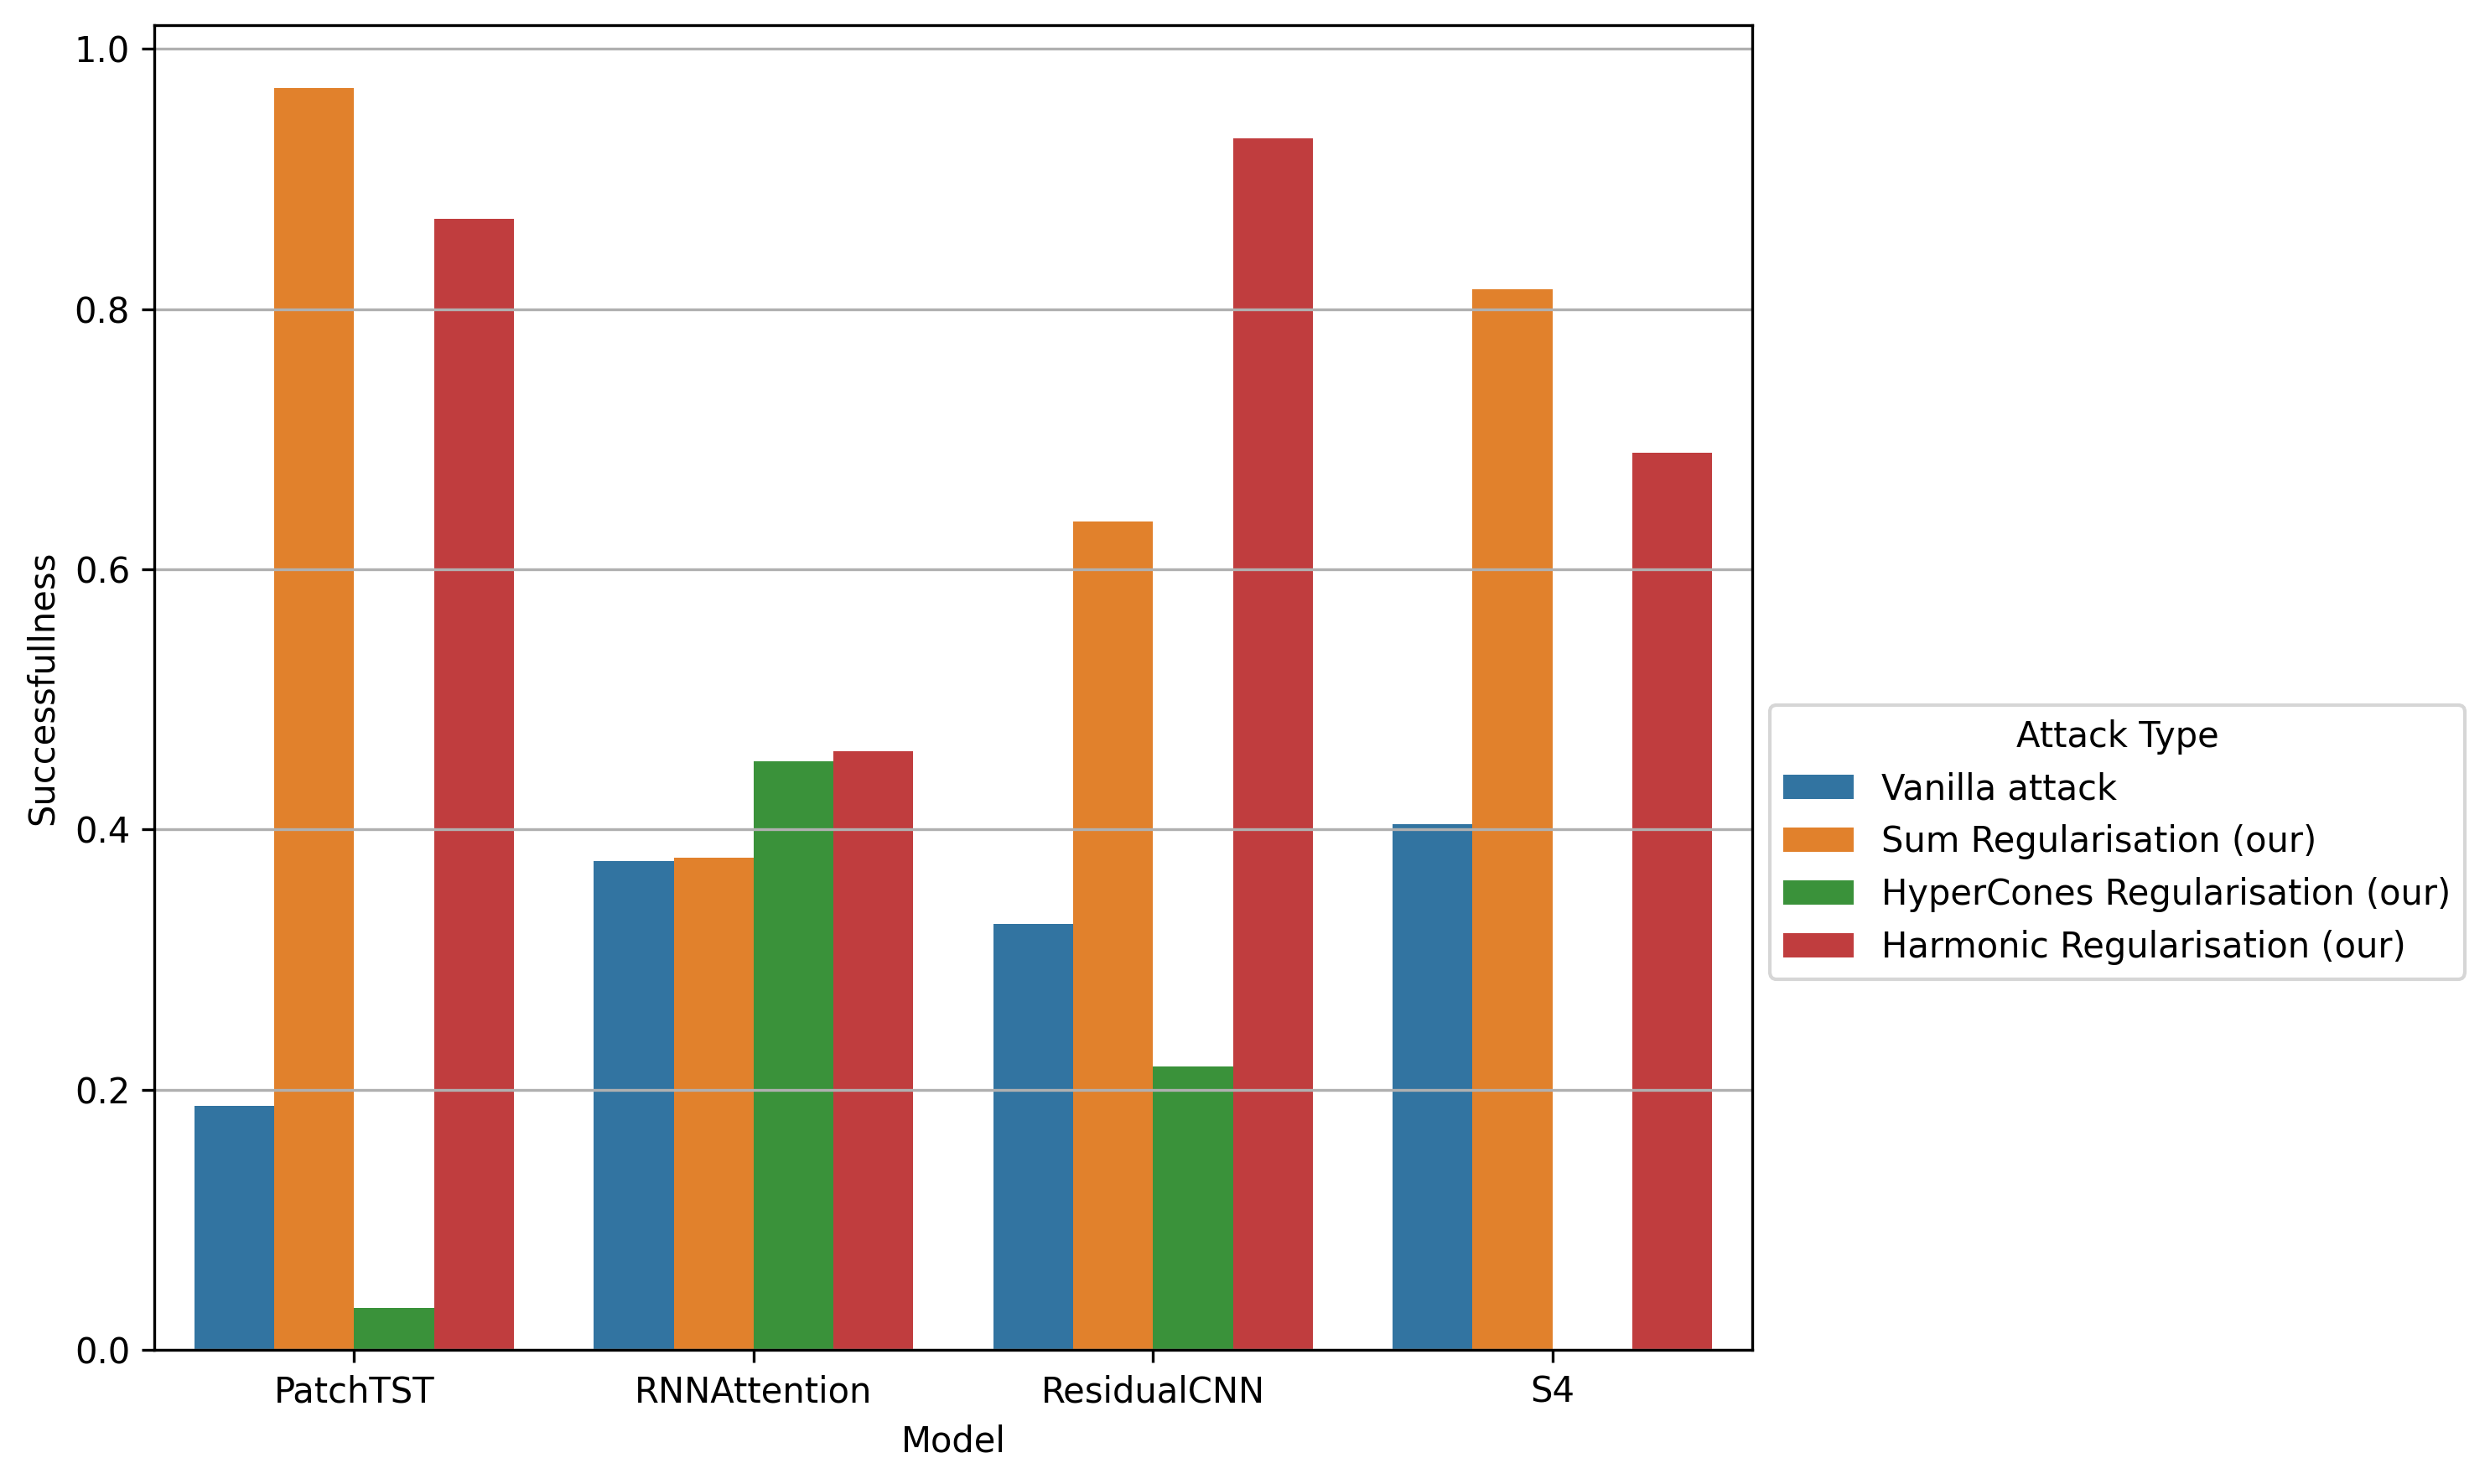

In [40]:
ds_plot = ['PowerCons'] #['GunPointMaleVersusFemale', 'Strawberry', 'PowerCons', 'GunPoint', 'Coffee', 'FreezerRegularTrain'] # ['PowerCons', 'GunPoint']
attacks_plot = ['fgsm', 'fgsm_disc', 'fgsm_harmonic', 'fgsm_disc_hypercones'] #'fgsm_disc_hypercones',

plot_data = grouped_data[(grouped_data['dataset'].isin(ds_plot)) & (grouped_data['attack'].isin(attacks_plot))]

attack_mapping = {
    'fgsm': 'Vanilla attack',
    'fgsm_disc': 'Sum Regularisation (our)',
    'fgsm_harmonic': 'Harmonic Regularisation (our)',
    'fgsm_disc_hypercones': 'HyperCones Regularisation (our)',
    'kll2': 'SGM'
}

model_mapping = {
    'RNNA': 'RNNAttention',
    'PatchTST': 'PatchTST',
    'S4': 'S4',
    'ResidualCNN': 'ResidualCNN',
}
plot_data['attack_label'] = plot_data['attack'].map(attack_mapping)
plot_data['model'] = plot_data['model'].map(model_mapping)

# Plotting
plt.figure(figsize=(10, 6), dpi=300)
sns.barplot(data=plot_data, x='model', y='F_EFF_CONC', hue='attack_label', errorbar=None)

plt.xlabel('Model')
plt.ylabel('Successfullness')
plt.legend(title='Attack Type', bbox_to_anchor=(1, 0.5))
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [51]:
filtered_metrics = metrics[filter_start_point_mask]
#filtered_metrics.groupby(by=['dataset', 'model', 'attack'])[metric_name].idxmax()
#grouped_data = metrics[filter_start_point_mask].loc[mask]

max_values = filtered_metrics.groupby(by=['dataset', 'model', 'attack'])[metric_name].transform(max)
table_data = filtered_metrics[filtered_metrics[metric_name] == max_values][['dataset', 'model', 'attack', metric_name, 'EFF', 'CONC']]
table_data = table_data.drop_duplicates(subset=['dataset', 'model', 'attack'])
table_data 


ds_plot = ['GunPointMaleVersusFemale', 'Strawberry', 'PowerCons', 'GunPoint', 'Coffee', 'FreezerRegularTrain'] #['PowerCons', 'GunPoint'] #['GunPointMaleVersusFemale', 'Strawberry', 'PowerCons', 'GunPoint', 'Coffee', 'FreezerRegularTrain']
attacks_plot = ['fgsm', 'fgsm_disc', 'fgsm_harmonic', 'kll2'] #'fgsm_disc_hypercones', 'kll2'

table_data = table_data[(table_data['dataset'].isin(ds_plot)) & (table_data['attack'].isin(attacks_plot))]
table_data = table_data.dropna()

attack_mapping = {
    'fgsm': 'Vanilla attack',
    'fgsm_disc': 'Sum Regularisation (our)',
    'fgsm_harmonic': 'Harmonic Regularisation (our)',
    'fgsm_disc_hypercones': 'HyperCones Regularisation (our)',
    'kll2': 'SGM'
}
table_data['attack'] = table_data['attack'].map(attack_mapping)

grouped = table_data.groupby('attack').mean()

# Вычисление средних рангов
rank_final = table_data.pivot(index='attack', columns=['dataset', 'model'], values=metric_name).rank(ascending=False).T.mean()
rank_effect = table_data.pivot(index='attack', columns=['dataset', 'model'], values='EFF').rank(ascending=False).T.mean()
rank_conceal = table_data.pivot(index='attack', columns=['dataset', 'model'], values='CONC').rank(ascending=False).T.mean()

# Создание итоговой таблицы
grouped_rank_mean_metrics = pd.DataFrame({
    'Success': grouped['F_EFF_CONC'],
    'Effect': grouped['EFF'],
    'Conceal': grouped['CONC'],
    'Mean Rank Success': rank_final,
    'Mean Rank Effect': rank_effect,
    'Mean Rank Conceal': rank_conceal
}).reset_index()

grouped_rank_mean_metrics.iloc[[3, 1, 0, 2]].round(3)

,attack,Success,Effect,Conceal,Mean Rank Success,Mean Rank Effect,Mean Rank Conceal
3,Vanilla attack,0.300,0.861,0.239,3.417,1.938,3.458
1,SGM,0.537,0.575,0.642,2.947,3.737,2.553
0,Harmonic Regularisation (our),0.814,0.848,0.815,1.714,1.810,1.881
2,Sum Regularisation (our),0.786,0.744,0.878,1.458,2.229,1.583


In [42]:
filtered_metrics

,iters,ACC,ACC_CORRECT,ACC_DISC,ACC_ORIG_ADV,CONC,EFF,F1,F1_DISC,F_EFF_CONC,...,alpha,eta,smoothness,mu,norm_coef,delta,seed,attack,attack_type,disc_attack
40,40.0,0.299649,0.306423,0.964912,0.321754,0.035714,0.768875,0.231125,0.964286,0.068258,...,0.0001,NaN,NaN,NaN,NaN,NaN,100,fgsm_disc,fgsm,True
41,41.0,0.291930,0.298529,0.968421,0.314035,0.032028,0.770817,0.229183,0.967972,0.061502,...,0.0001,NaN,NaN,NaN,NaN,NaN,100,fgsm_disc,fgsm,True
42,42.0,0.281053,0.287406,0.973684,0.303158,0.026549,0.773499,0.226501,0.973451,0.051335,...,0.0001,NaN,NaN,NaN,NaN,NaN,100,fgsm_disc,fgsm,True
43,43.0,0.274386,0.280588,0.975088,0.296491,0.025097,0.775112,0.224888,0.974903,0.048620,...,0.0001,NaN,NaN,NaN,NaN,NaN,100,fgsm_disc,fgsm,True
44,44.0,0.265614,0.271618,0.980175,0.287719,0.019870,0.777200,0.222800,0.980130,0.038749,...,0.0001,NaN,NaN,NaN,NaN,NaN,100,fgsm_disc,fgsm,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
316372,46.0,0.494700,0.985300,0.878200,0.992600,0.137800,0.338300,0.661700,0.862200,0.195832,...,NaN,0.1,NaN,NaN,NaN,NaN,100,pgd,pgd,False
316373,47.0,0.495100,0.986000,0.879500,0.993000,0.136200,0.338000,0.662000,0.863800,0.194161,...,NaN,0.1,NaN,NaN,NaN,NaN,100,pgd,pgd,False
316374,48.0,0.495100,0.986000,0.880700,0.993000,0.134600,0.338000,0.662000,0.865400,0.192530,...,NaN,0.1,NaN,NaN,NaN,NaN,100,pgd,pgd,False
316375,49.0,0.495100,0.986000,0.881400,0.993000,0.133700,0.338000,0.662000,0.866300,0.191607,...,NaN,0.1,NaN,NaN,NaN,NaN,100,pgd,pgd,False


In [43]:
table_data.iloc[:, :3].drop_duplicates()

,dataset,model,attack
662,FreezerRegularTrain,RNNA,Sum Regularisation (our)
1571,FreezerRegularTrain,RNNA,Vanilla attack
1740,FreezerRegularTrain,ResidualCNN,Sum Regularisation (our)
3064,FreezerRegularTrain,ResidualCNN,Vanilla attack
3322,FreezerRegularTrain,S4,Vanilla attack
...,...,...,...
271166,FreezerRegularTrain,ResidualCNN,SGM
284152,FreezerRegularTrain,PatchTST,SGM
295948,FreezerRegularTrain,PatchTST,Harmonic Regularisation (our)
297483,FreezerRegularTrain,S4,SGM


In [44]:
table_data.pivot(index='attack', columns=['dataset', 'model'], values=metric_name)

dataset                       FreezerRegularTrain                        \
model                                        RNNA ResidualCNN        S4   
attack                                                                    
Harmonic Regularisation (our)                 NaN    0.994310       NaN   
SGM                                      0.242931    0.991560  0.460167   
Sum Regularisation (our)                 0.943598    0.997156  0.951026   
Vanilla attack                           0.075926    0.996297  0.089920   

dataset                                 Strawberry                        \
model                          PatchTST       RNNA ResidualCNN        S4   
attack                                                                     
Harmonic Regularisation (our)  0.995098   0.943253    0.965047  0.744869   
SGM                            0.457138   0.575566    0.544486  0.427445   
Sum Regularisation (our)       0.999649   0.537220    0.450000  0.799281   
Vanilla attack                 0.051125   0.000000    0.078015  0.119938   

dataset                                 GunPointMaleVersusFemale              \
model                          PatchTST                       S4 ResidualCNN   
attack                                                                         
Harmonic Regularisation (our)  0.921031                 0.359678    0.778477   
SGM                            0.653757                      NaN         NaN   
Sum Regularisation (our)       0.769412                 0.581498    1.000000   
Vanilla attack                 0.052899                 0.156490    0.335443   

dataset                        ...    Coffee    GunPoint                      \
model                          ...      RNNA ResidualCNN  PatchTST      RNNA   
attack                         ...                                             
Harmonic Regularisation (our)  ...  1.000000    0.859069  0.767398  0.459635   
SGM                            ...  1.000000    0.537612  0.503475       NaN   
Sum Regularisation (our)       ...  1.000000    0.736352  0.802195  0.512798   
Vanilla attack                 ...  0.661935    0.274724  0.019608  0.013158   

dataset                                      Coffee PowerCons              \
model                                S4 ResidualCNN        S4 ResidualCNN   
attack                                                                      
Harmonic Regularisation (our)  0.863767    1.000000  0.689345    0.931093   
SGM                            0.474929    0.964267       NaN    0.401368   
Sum Regularisation (our)       0.885965    1.000000  0.815236    0.636412   
Vanilla attack                 0.293982    1.000000  0.403973    0.327733   

dataset                                            
model                          PatchTST      RNNA  
attack                                             
Harmonic Regularisation (our)  0.869322  0.459932  
SGM                            0.198937  0.128160  
Sum Regularisation (our)       0.969709  0.378611  
Vanilla attack                 0.187371  0.375644  

[4 rows x 24 columns]

In [45]:
table_data[table_data['attack'] == 'Sum Regularisation (our)'].sort_values(['dataset', 'model', 'attack'])

,dataset,model,attack,F_EFF_CONC,EFF,CONC
21358,Coffee,PatchTST,Sum Regularisation (our),1.000000,1.000000,1.000000
22241,Coffee,RNNA,Sum Regularisation (our),1.000000,1.000000,1.000000
28425,Coffee,ResidualCNN,Sum Regularisation (our),1.000000,1.000000,1.000000
20182,Coffee,S4,Sum Regularisation (our),1.000000,1.000000,1.000000
6476,FreezerRegularTrain,PatchTST,Sum Regularisation (our),0.999649,1.000000,0.999299
662,FreezerRegularTrain,RNNA,Sum Regularisation (our),0.943598,0.911385,0.978172
1740,FreezerRegularTrain,ResidualCNN,Sum Regularisation (our),0.997156,0.999217,0.995103
4028,FreezerRegularTrain,S4,Sum Regularisation (our),0.951026,0.917003,0.987671
25661,GunPoint,PatchTST,Sum Regularisation (our),0.802195,0.675676,0.987013
25911,GunPoint,RNNA,Sum Regularisation (our),0.512798,0.513158,0.512438


/tmp/ipykernel_558137/3294141329.py:14: UserWarning: The markers list has more values (6) than needed (4), which may not be intended.
  sns.scatterplot(


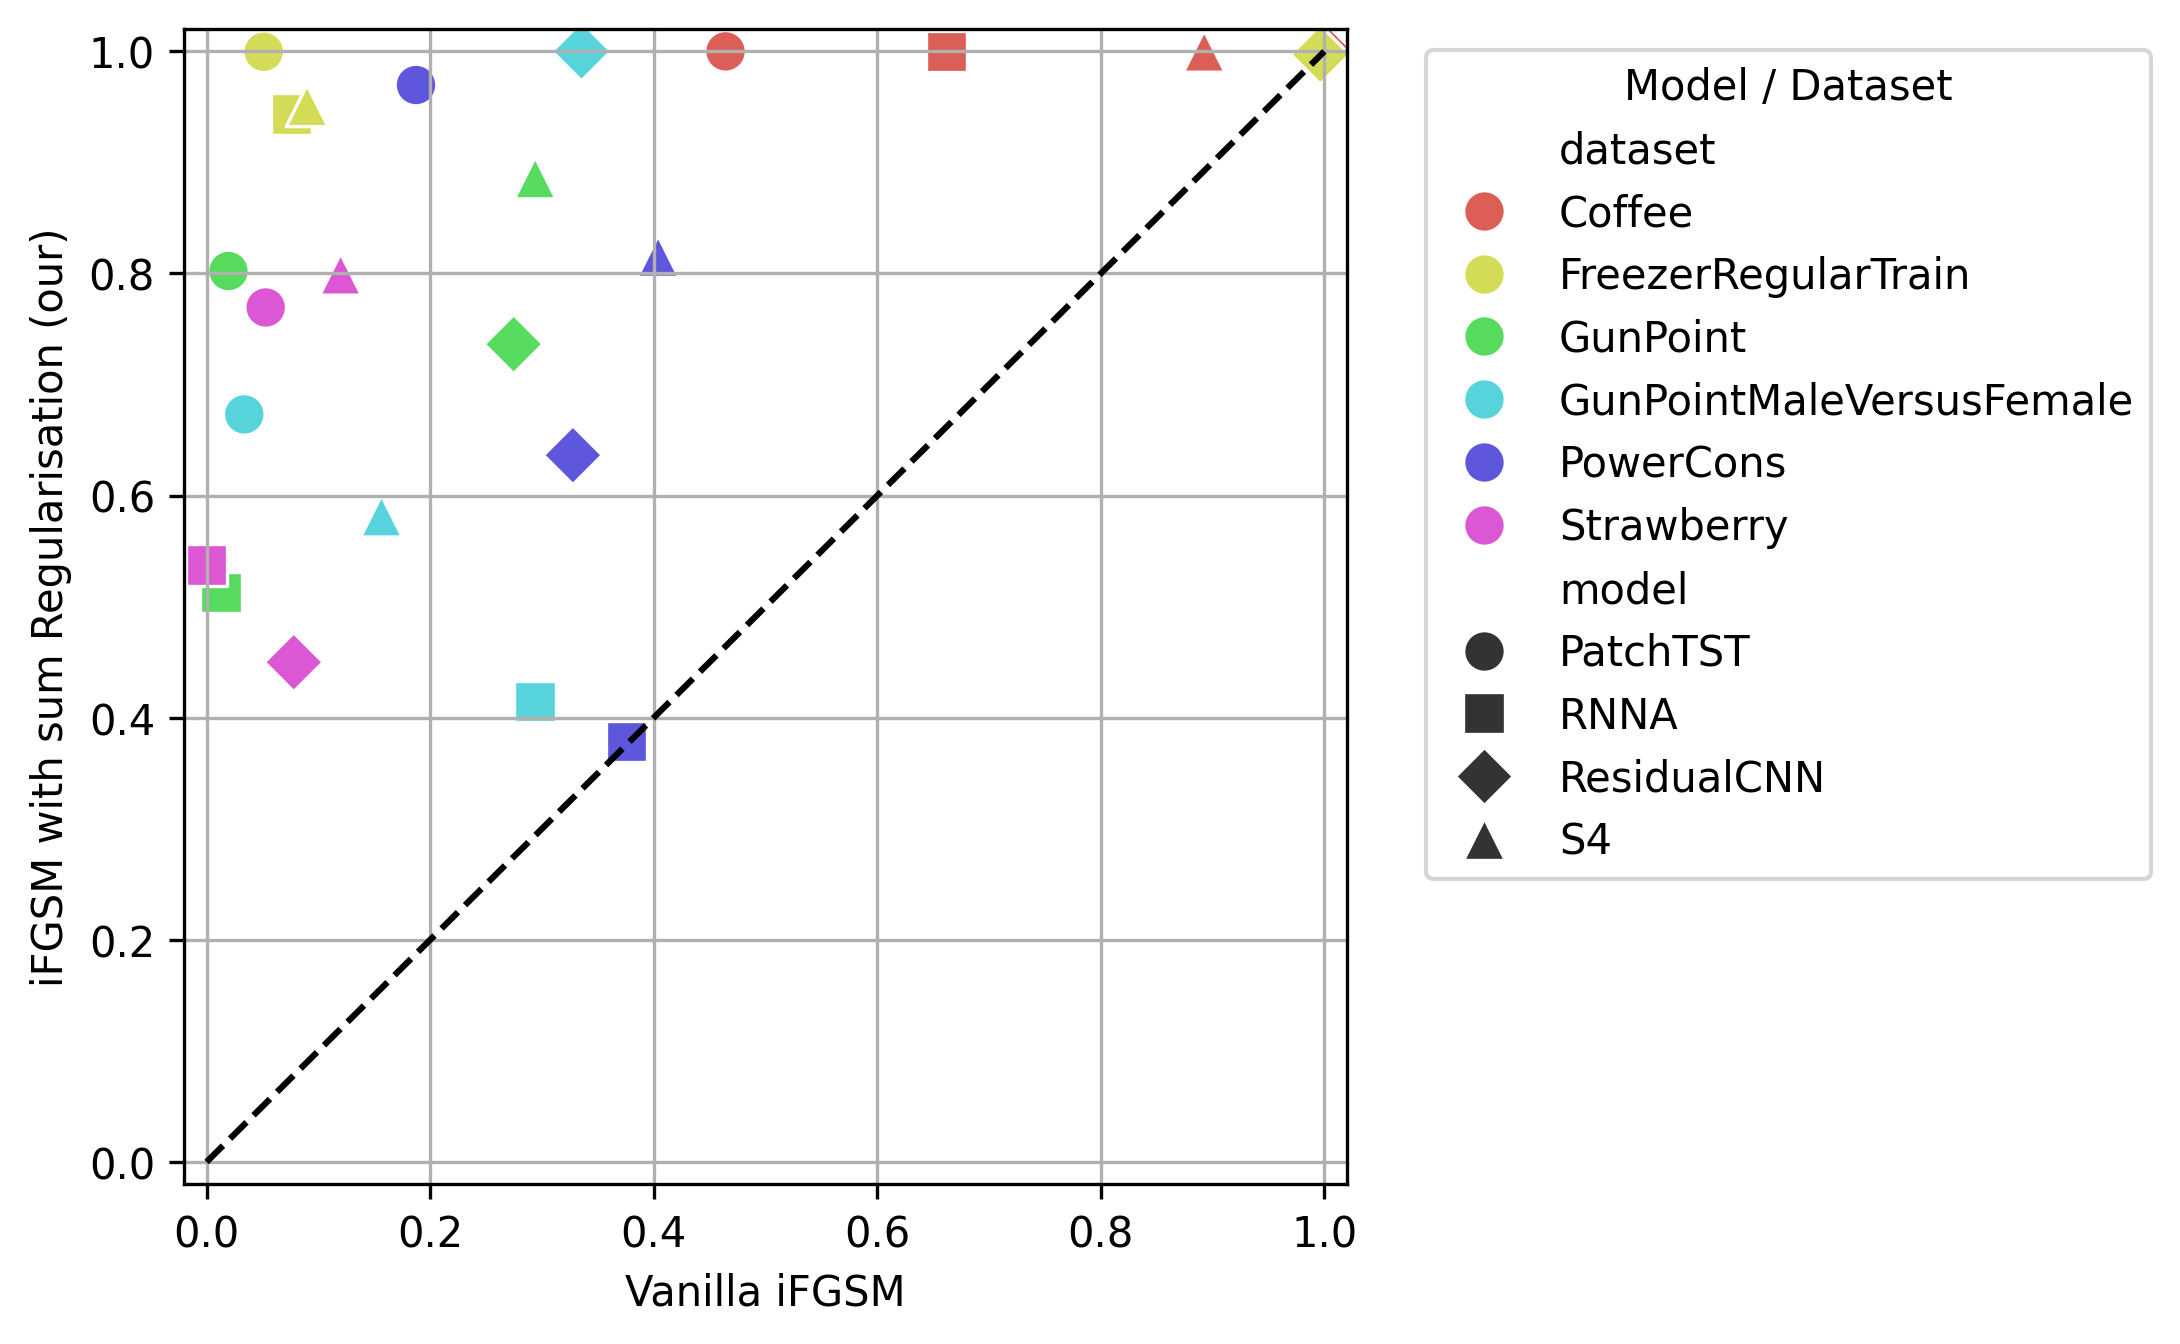

In [48]:
draw_scatter_pair_metrics(agg_data, 'fgsm', 'fgsm_disc', x_col_name='Vanilla iFGSM', y_col_name='iFGSM with sum Regularisation (our)', title='')

/tmp/ipykernel_558137/3294141329.py:14: UserWarning: The markers list has more values (6) than needed (4), which may not be intended.
  sns.scatterplot(


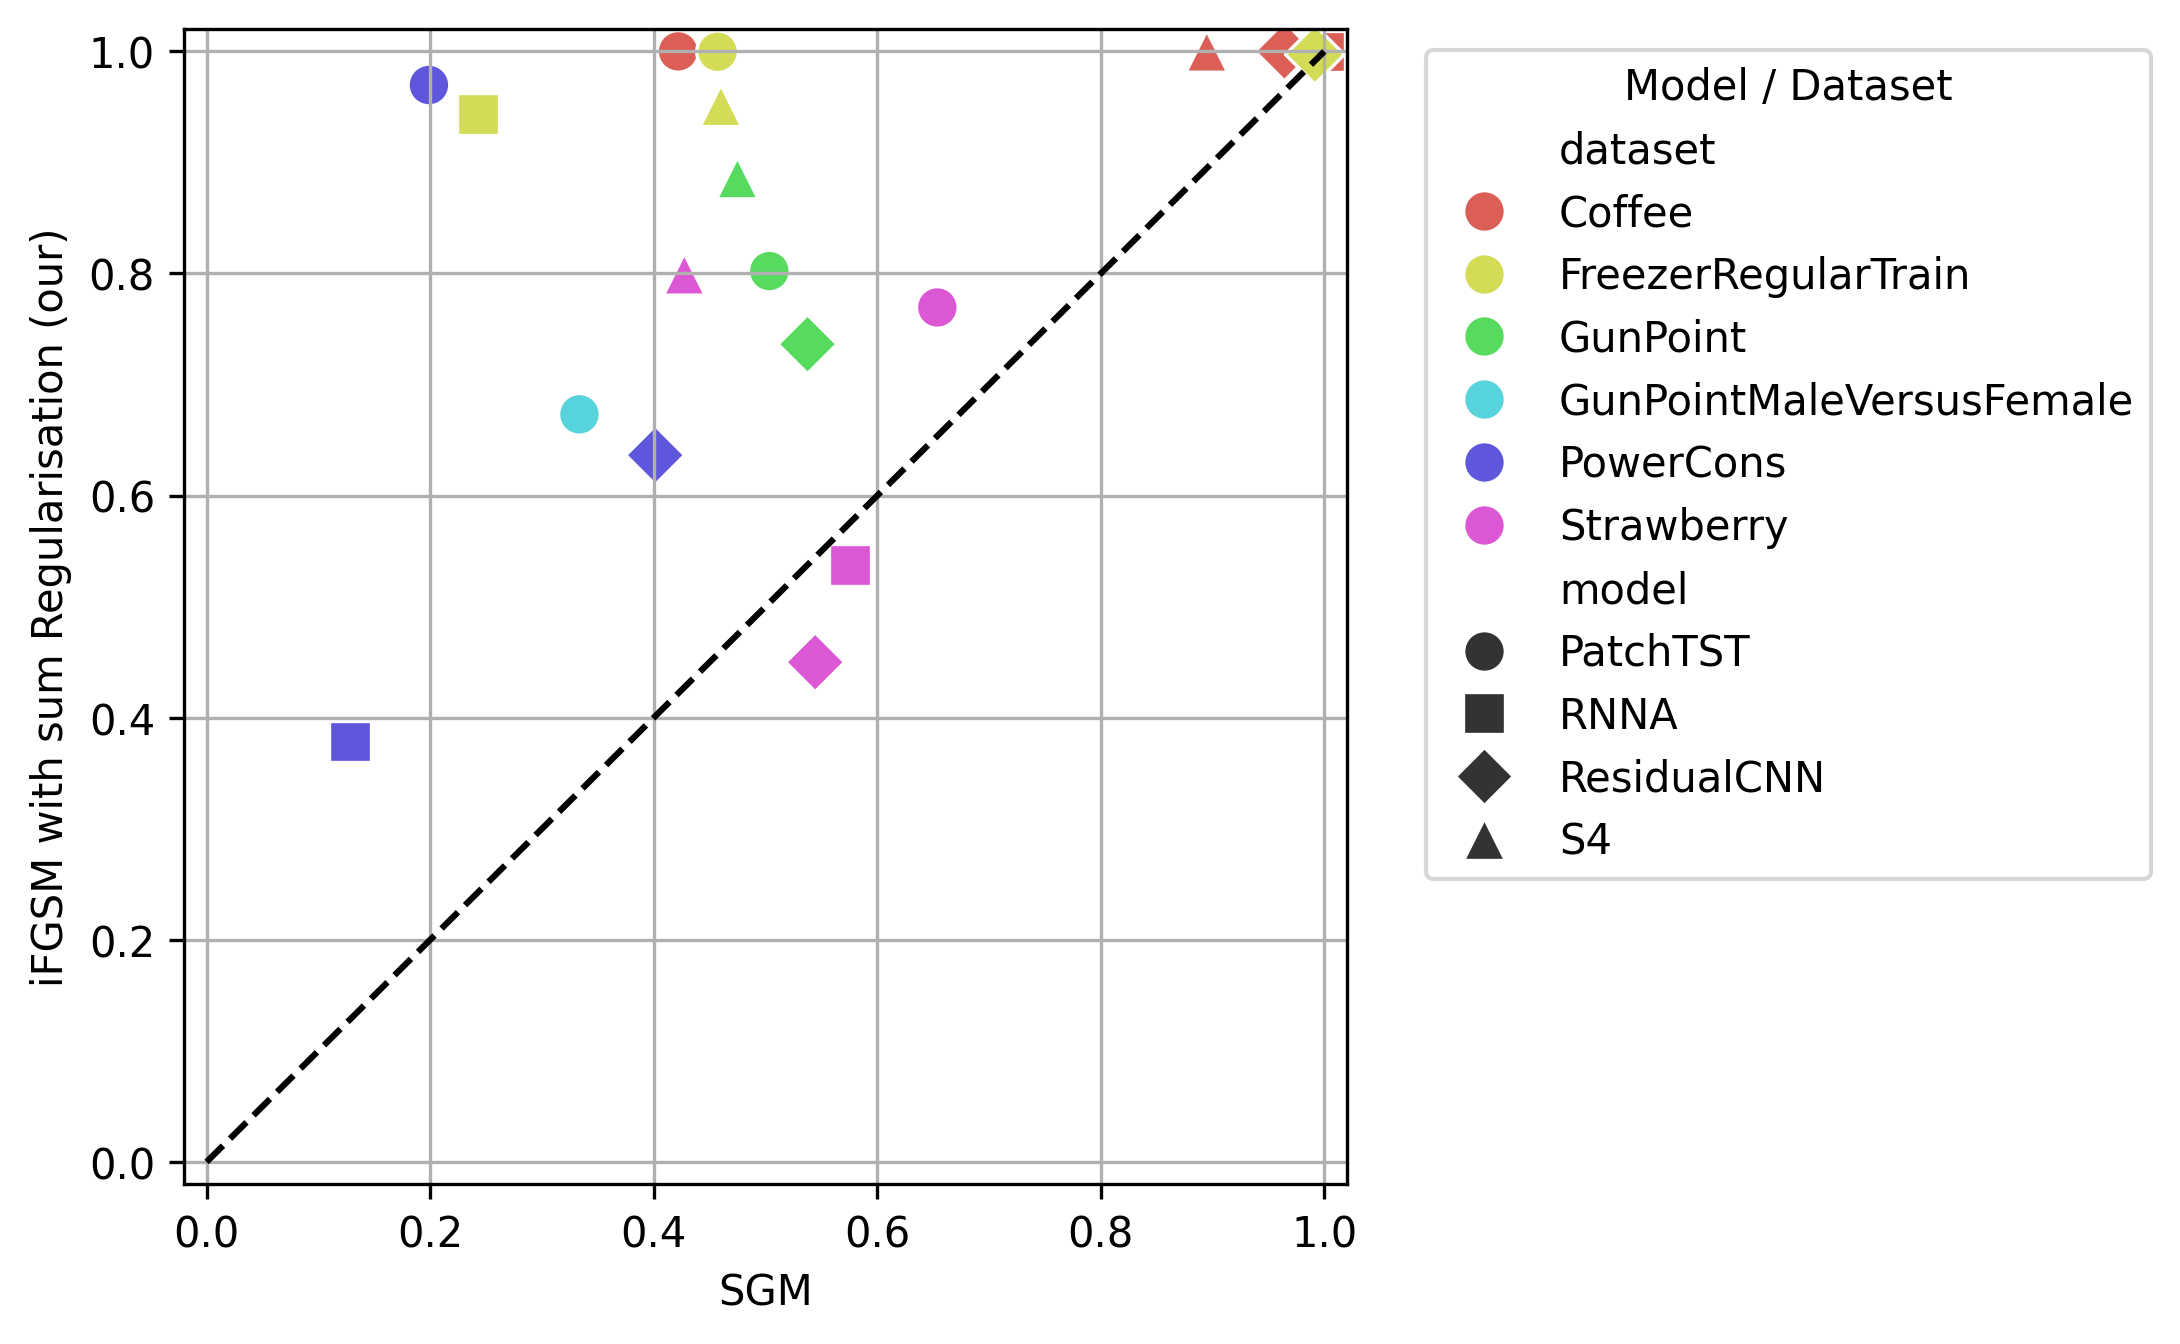

In [49]:
draw_scatter_pair_metrics(agg_data, 'kll2', 'fgsm_disc', x_col_name='SGM', y_col_name='iFGSM with sum Regularisation (our)', title='')

/tmp/ipykernel_558137/3294141329.py:14: UserWarning: The markers list has more values (6) than needed (4), which may not be intended.
  sns.scatterplot(


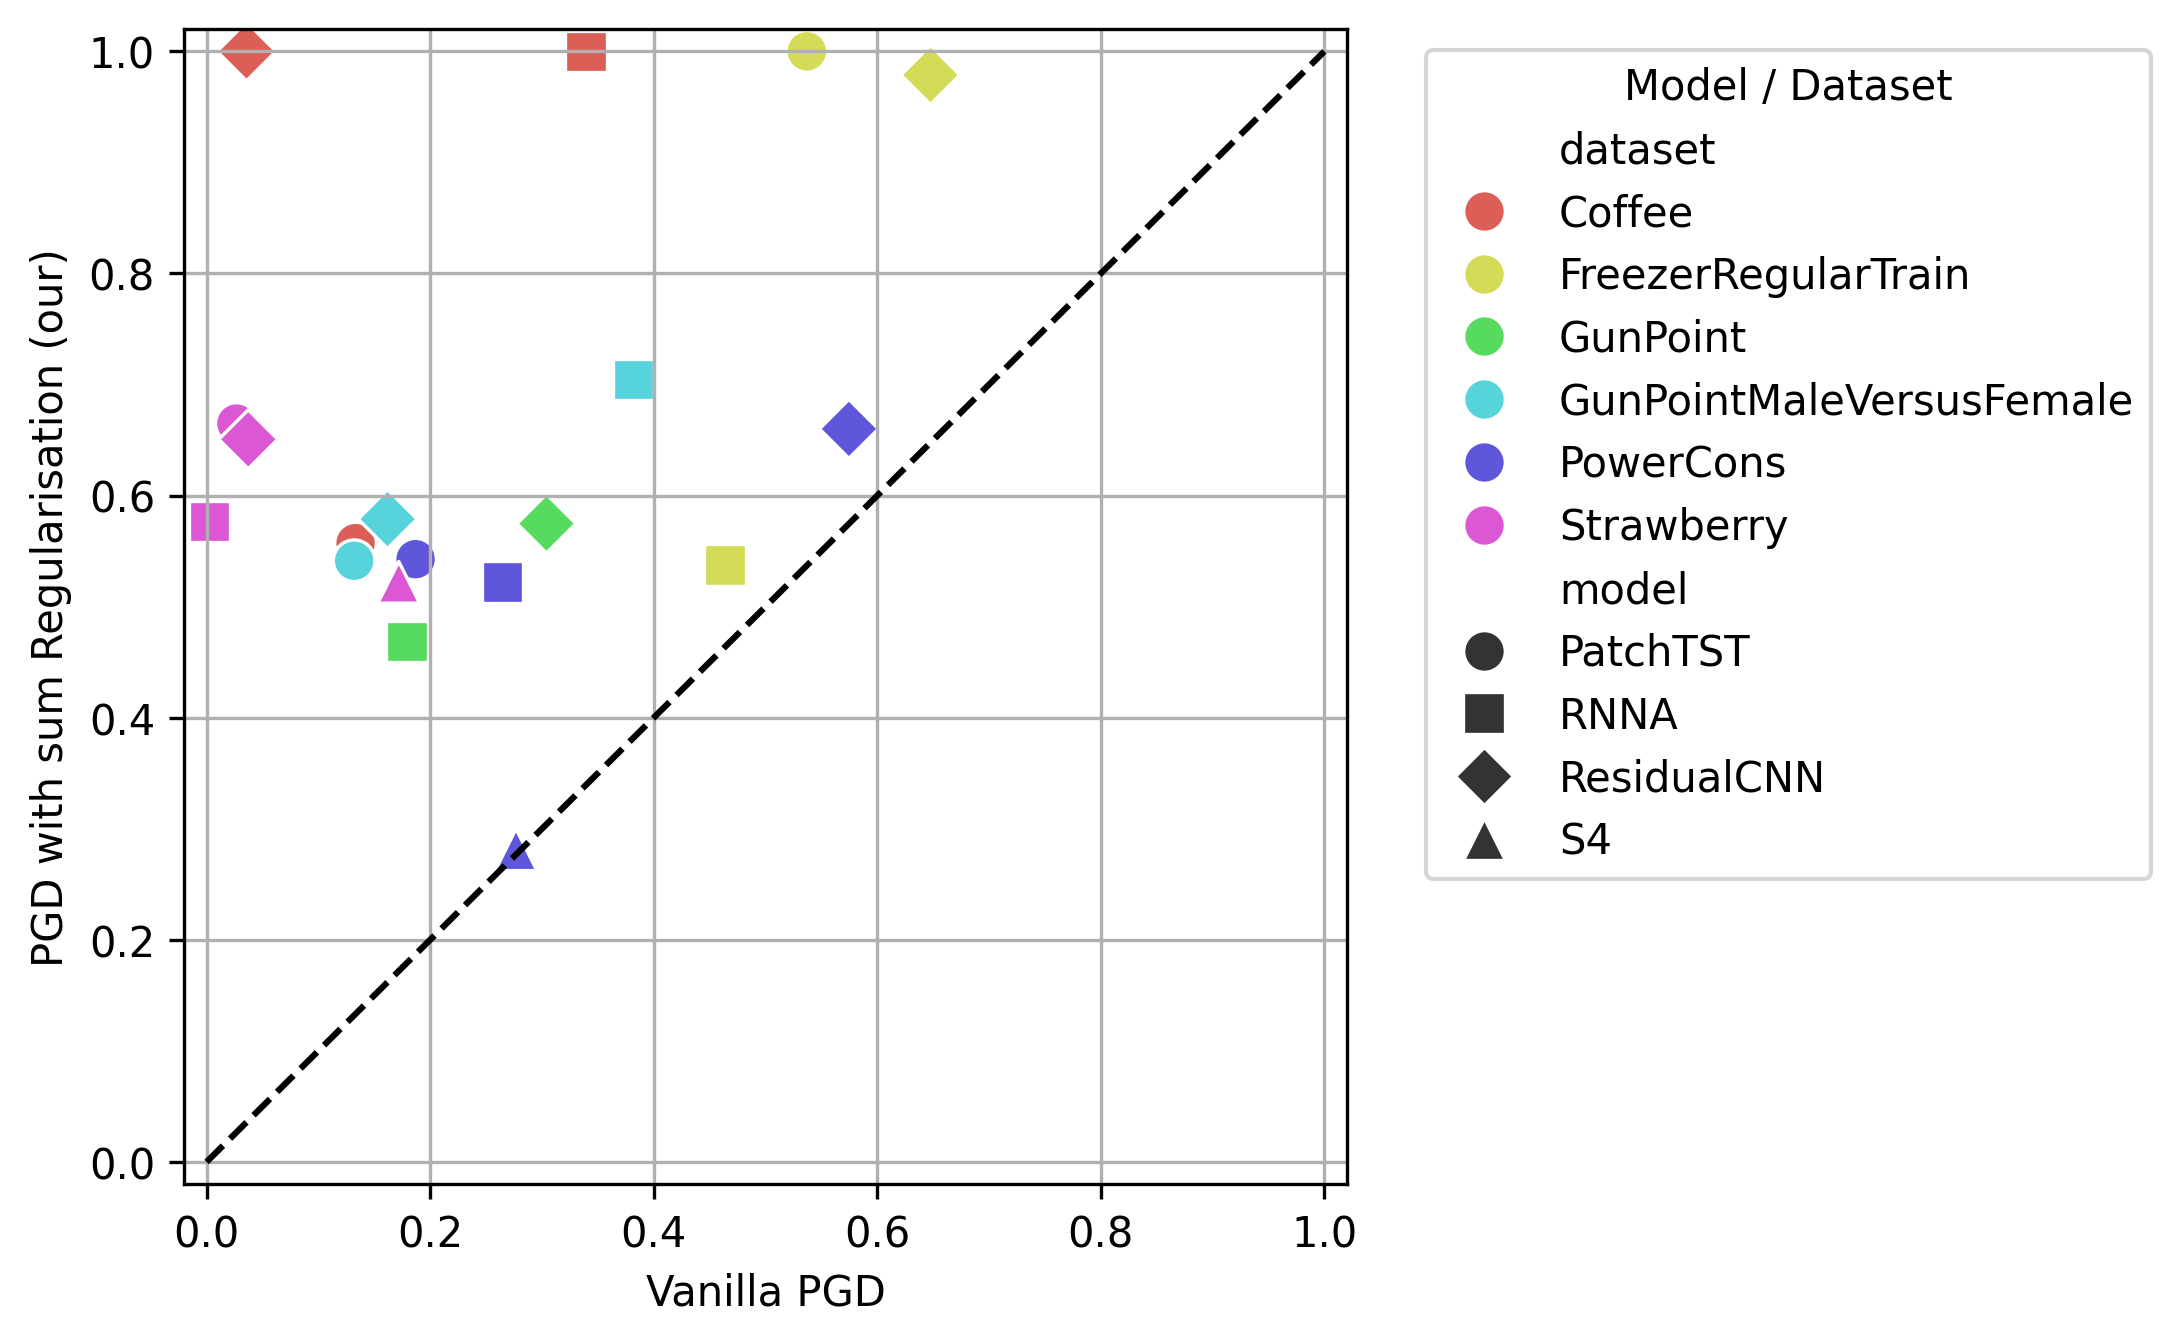

In [50]:
draw_scatter_pair_metrics(agg_data, 'pgd', 'pgd_disc', x_col_name='Vanilla PGD', y_col_name='PGD with sum Regularisation (our)', title='')

In [31]:
raise ValueError

ValueError: 

# Examples

In [ ]:
# changing core directory
import os
import sys

dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if dir1 not in sys.path:
    sys.path.append(dir1)
os.chdir('..')

In [ ]:
import copy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

# from src.attacks import fgsm_attack, only_disc_attack
# from src.attacks.utils import calculate_metrics_class_and_hiddens, req_grad
from src.config import get_disc_list
from src.data import MyDataset, load_data, transform_data
from src.models.LSTM import LSTM
# from src.utils import load_disc_model

In [ ]:
from hydra import compose, initialize
from omegaconf import OmegaConf
initialize(config_path='../config', version_base=None)
cfg = compose(config_name='attack_run_config.yaml')
print(OmegaConf.to_yaml(cfg))

In [ ]:
import os
import warnings

import hydra
import pandas as pd
import torch
from omegaconf import DictConfig
from torch.utils.data import DataLoader

from src.config import get_attack, get_criterion, get_disc_list, get_model
from src.data import MyDataset, load_data, transform_data
from src.estimation.estimators import AttackEstimator
from src.utils import save_experiment

In [ ]:
X_train, y_train, X_test, y_test = load_data(cfg['dataset'])
X_train, X_test, y_train, y_test = transform_data(X_train, X_test, y_train, y_test, slice_data=cfg['slice'])

test_loader = DataLoader(
    MyDataset(X_test, y_test), 
    batch_size=cfg['batch_size'] , 
    shuffle=True
    )


device = torch.device(cfg["cuda"] if torch.cuda.is_available() else "cpu")

attack_model_path = os.path.join(
    cfg["model_folder"],
    cfg["attack_model"]["name"],
    f"model_{cfg['model_id_attack']}_{cfg['dataset']}.pt",
)

attack_model = get_model(
    cfg["attack_model"]["name"],
    cfg["attack_model"]["params"],
    path=attack_model_path,
    device=device,
    train_mode=cfg["attack_model"]["attack_train_mode"],
)

In [ ]:
criterion = get_criterion(cfg["criterion_name"], cfg["criterion_params"])

disc_check_list = (
    get_disc_list(
        model_name=cfg["disc_model_check"]["name"],
        model_params=cfg["disc_model_check"]["params"],
        list_disc_params=cfg["list_check_model_params"],
        device=device,
        path=cfg["disc_path"],
        train_mode=False,
    )
    if cfg["use_disc_check"]
    else None
)
estimator = AttackEstimator(disc_check_list, cfg["metric_effect"])

In [ ]:
alpha = 1
eps = 0.03

In [ ]:
attack_metrics = pd.DataFrame()
attack_params = dict(cfg["attack"]["attack_params"])
attack_params["model"] = attack_model
attack_params["criterion"] = criterion
attack_params["estimator"] = estimator
attack_params["alpha"] = alpha
attack_params["eps"] = eps

if "list_reg_model_params" in cfg["attack"]:
    attack_params["disc_models"] = get_disc_list(
        model_name=cfg["disc_model_reg"]["name"],
        model_params=cfg["disc_model_reg"]["params"],
        list_disc_params=cfg["attack"]["list_reg_model_params"],
        device=device,
        path=cfg["disc_path"],
        train_mode=cfg["disc_model_reg"]["attack_train_mode"],
    )

attack = get_attack(cfg["attack"]["name"], attack_params)
X_adv = attack.apply_attack(test_loader).squeeze(-1)

results = attack.get_metrics()
results["eps"] = eps
attack_metrics = pd.concat([attack_metrics, results])